Packages used:

In [1]:
pip install numpy pandas scikit-learn matplotlib seaborn tensorflow


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing the picture data. Please adjust the file path to your own local directory if downlaoded the link for the data is here: https://business.yelp.com/data/resources/open-dataset/


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tarfile
from sklearn.decomposition import PCA
from io import BytesIO

# --------------------
# Constants / Parameters
# --------------------
tar_path = r"C:\Users\darkr\Downloads\yelp\YelpPhotos\yelp_photos.tar"  # Path to your tar file
N_COMPONENTS = 50                # PCA components for feature reduction
TARGET_IMAGES_PER_CSV = 10000   # Each CSV will have 10,000 images (or as many as available)
NUM_CSV_FILES = 5                # Total number of CSVs to generate
RESIZE_DIM = (128, 128)          # Resize images to 128x128 pixels

# --------------------
# Generator function to yield images one by one from the tar file
# --------------------
def generate_images_from_tar(tar_path):
    """
    Yields a tuple (resized_image, filename) for each image in the tar file.
    Only processes files with .jpg or .png extensions.
    """
    with tarfile.open(tar_path, 'r') as tar:
        for member in tar:
            if member.isfile() and member.name.endswith(('.jpg', '.png')):
                f = tar.extractfile(member)
                if f:
                    img_data = f.read()
                    # Decode image as grayscale
                    img_array = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_GRAYSCALE)
                    if img_array is not None:
                        # Resize image for consistency
                        resized_img = cv2.resize(img_array, RESIZE_DIM)
                        yield resized_img, os.path.basename(member.name)

# --------------------
# Function to apply PCA on a batch of images
# --------------------
def apply_pca(image_data, n_components=N_COMPONENTS):
    """
    Flattens each image and applies PCA for dimensionality reduction.
    Args:
        image_data (np.array): Array of images with shape (num_samples, height, width)
        n_components (int): Number of PCA components
    Returns:
        reduced_features (np.array): Array with shape (num_samples, n_components)
    """
    num_samples = image_data.shape[0]
    flat_images = image_data.reshape(num_samples, -1)  # Flatten each image
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(flat_images)
    return reduced_features

# --------------------
# Main processing loop:
# Extract images sequentially from the tar file, process in groups of TARGET_IMAGES_PER_CSV,
# apply PCA, and then write each group to a numbered CSV.
# --------------------
csv_count = 0           # Counts how many CSV files have been generated
global_images_processed = 0  # Overall count of processed images

# Create the generator object for the tar file
image_generator = generate_images_from_tar(tar_path)

while csv_count < NUM_CSV_FILES:
    current_images = []    # Will hold the images for the current CSV
    current_filenames = [] # Corresponding filenames for the current CSV

    # Collect TARGET_IMAGES_PER_CSV images for this CSV
    while len(current_images) < TARGET_IMAGES_PER_CSV:
        try:
            img, filename = next(image_generator)
            current_images.append(img)
            current_filenames.append(filename)
            global_images_processed += 1
            if global_images_processed % 1000 == 0:
                print(f"Processed {global_images_processed} images so far...")
        except StopIteration:
            print("Reached end of tar file.")
            break  # No more images available

    if not current_images:
        print("No images collected for this CSV. Exiting loop.")
        break

    # Convert the list of images to a NumPy array
    images_np = np.array(current_images)
    print(f"\nProcessing CSV file {csv_count+1} with {images_np.shape[0]} images.")
    
    # Apply PCA reduction on the batch of images
    pca_features = apply_pca(images_np)

    # Create a DataFrame with PCA features and add filenames as the first column
    df_batch = pd.DataFrame(pca_features)
    df_batch.insert(0, "image_filename", current_filenames)
    
    # Save the DataFrame to a CSV file (numbered accordingly)
    output_csv = os.path.join(r"C:\Users\darkr\Downloads", f"yelp_image_pca_features_{csv_count+1}.csv")
    df_batch.to_csv(output_csv, index=False)
    print(f"Saved CSV {csv_count+1} to {output_csv}")

    csv_count += 1

print(f"\nTotal images processed: {global_images_processed}")


Processed 1000 images so far...
Processed 2000 images so far...
Processed 3000 images so far...
Processed 4000 images so far...
Processed 5000 images so far...
Processed 6000 images so far...
Processed 7000 images so far...
Processed 8000 images so far...
Processed 9000 images so far...
Processed 10000 images so far...

Processing CSV file 1 with 10000 images.
Saved CSV 1 to C:\Users\darkr\Downloads\yelp_image_pca_features_1.csv
Processed 11000 images so far...
Processed 12000 images so far...
Processed 13000 images so far...
Processed 14000 images so far...
Processed 15000 images so far...
Processed 16000 images so far...
Processed 17000 images so far...
Processed 18000 images so far...
Processed 19000 images so far...
Processed 20000 images so far...

Processing CSV file 2 with 10000 images.
Saved CSV 2 to C:\Users\darkr\Downloads\yelp_image_pca_features_2.csv
Processed 21000 images so far...
Processed 22000 images so far...
Processed 23000 images so far...
Processed 24000 images so 

Make merged CSV's with the other bussiness.json file from the other download package. Make sure to change directories! Make 5 csv's for 20/80 testing. each has 10,000 photos. this compromises 25% of the neormous dataset

In [2]:
import os
import pandas as pd
import jsonlines

# ---------- Configuration ----------

# Path to the extracted photo metadata CSV (from your JSON extraction code)
photo_metadata_csv = r"C:\Users\darkr\Downloads\yelp_photo_metadata.csv"

# Path to the business JSON file
business_json_file = r"C:\Users\darkr\Downloads\Yelp-JSON\Yelp JSON\yelp_academic_dataset_business.json"

# Directory and filename pattern for the 5 PCA CSV files
pca_csv_pattern = r"C:\Users\darkr\Downloads\yelp_image_pca_features_{}.csv"  # {} will be replaced by 1 to 5

# Output pattern for final merged CSV files
merged_csv_pattern = r"C:\Users\darkr\Downloads\yelp_merged_data_{}.csv"  # {} will be replaced by 1 to 5

# ---------- Step 1: Load Photo Metadata and Business Data ----------

print("Loading photo metadata from:", photo_metadata_csv)
photo_metadata_df = pd.read_csv(photo_metadata_csv)

print("Loading business data from:", business_json_file)
business_data = []
with jsonlines.open(business_json_file) as reader:
    for obj in reader:
        business_data.append(obj)
df_business = pd.DataFrame(business_data)
print(f"Business data loaded: {df_business.shape[0]} rows, {df_business.shape[1]} columns")

# ---------- Step 2: Loop Over the 5 PCA CSV Files ----------

for i in range(1, 6):
    pca_csv_path = pca_csv_pattern.format(i)
    merged_output_csv = merged_csv_pattern.format(i)
    
    print(f"\nProcessing PCA CSV file: {pca_csv_path}")
    pca_df = pd.read_csv(pca_csv_path)
    
    # Check that required columns exist
    if "image_filename" not in pca_df.columns:
        print(f"❌ 'image_filename' column missing in {pca_csv_path}. Skipping.")
        continue
    if "photo_id" not in photo_metadata_df.columns:
        print("❌ 'photo_id' column missing in photo metadata. Ensure your JSON extraction created it.")
        break

    # Create a 'photo_id' column in PCA data by stripping the extension from image_filename
    pca_df["photo_id"] = pca_df["image_filename"].str.replace(r"\..*$", "", regex=True)
    
    # ---------- Step 3: Merge PCA data with Photo Metadata ----------
    merged_df = pd.merge(photo_metadata_df, pca_df, on="photo_id", how="inner")
    print(f"After merging PCA and photo metadata: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
    
    # ---------- Step 4: Merge with Business Data on business_id ----------
    if "business_id" in merged_df.columns and "business_id" in df_business.columns:
        final_merged_df = pd.merge(merged_df, df_business, on="business_id", how="left")
        print(f"After merging with business data: {final_merged_df.shape[0]} rows, {final_merged_df.shape[1]} columns")
    else:
        print("❌ 'business_id' missing in one of the datasets. Skipping merge with business data.")
        continue
    
    # ---------- Step 5: Save the Final Merged CSV ----------
    final_merged_df.to_csv(merged_output_csv, index=False)
    print(f"✅ Final merged CSV saved: {merged_output_csv}")


Loading photo metadata from: C:\Users\darkr\Downloads\yelp_photo_metadata.csv
Loading business data from: C:\Users\darkr\Downloads\Yelp-JSON\Yelp JSON\yelp_academic_dataset_business.json
Business data loaded: 150346 rows, 14 columns

Processing PCA CSV file: C:\Users\darkr\Downloads\yelp_image_pca_features_1.csv
After merging PCA and photo metadata: 10000 rows, 55 columns
After merging with business data: 10000 rows, 68 columns
✅ Final merged CSV saved: C:\Users\darkr\Downloads\yelp_merged_data_1.csv

Processing PCA CSV file: C:\Users\darkr\Downloads\yelp_image_pca_features_2.csv
After merging PCA and photo metadata: 10002 rows, 55 columns
After merging with business data: 10002 rows, 68 columns
✅ Final merged CSV saved: C:\Users\darkr\Downloads\yelp_merged_data_2.csv

Processing PCA CSV file: C:\Users\darkr\Downloads\yelp_image_pca_features_3.csv
After merging PCA and photo metadata: 10000 rows, 55 columns
After merging with business data: 10000 rows, 68 columns
✅ Final merged CSV sav

Some quick visualization of the csv's


Analyzing file: C:\Users\darkr\Downloads\yelp_merged_data_1.csv
Dataset Shape: (10000, 68)
Unique businesses: 7416

Missing values per column:
 photo_id             0
business_id          0
caption           5199
label                0
image_filename       0
                  ... 
review_count         0
is_open              0
attributes          17
categories           0
hours              282
Length: 68, dtype: int64


C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\2704016425.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


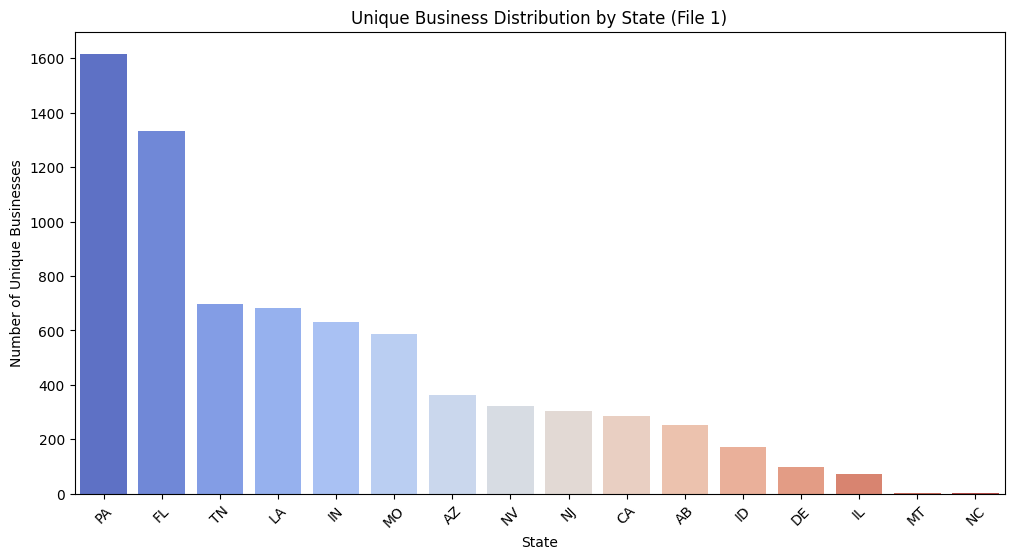

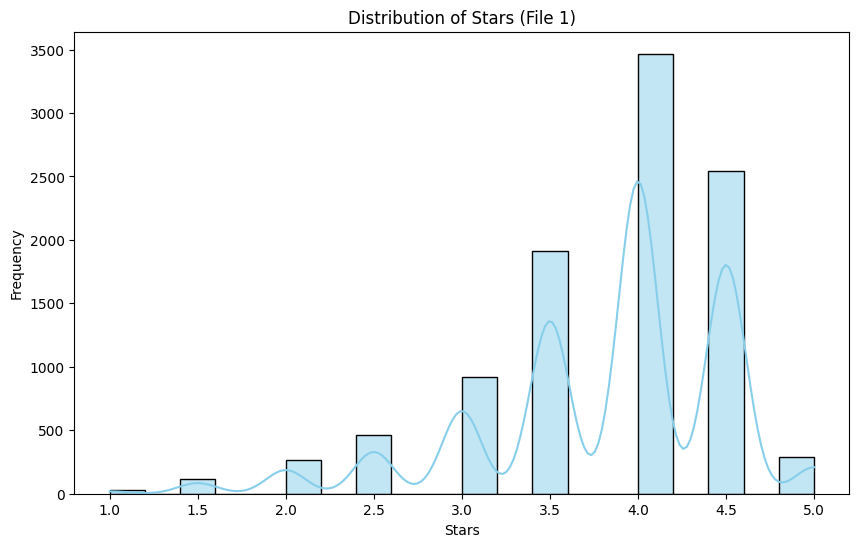


Analyzing file: C:\Users\darkr\Downloads\yelp_merged_data_2.csv
Dataset Shape: (10002, 68)
Unique businesses: 7410

Missing values per column:
 photo_id             0
business_id          0
caption           5049
label                0
image_filename       0
                  ... 
review_count         0
is_open              0
attributes          20
categories           0
hours              271
Length: 68, dtype: int64


C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\2704016425.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


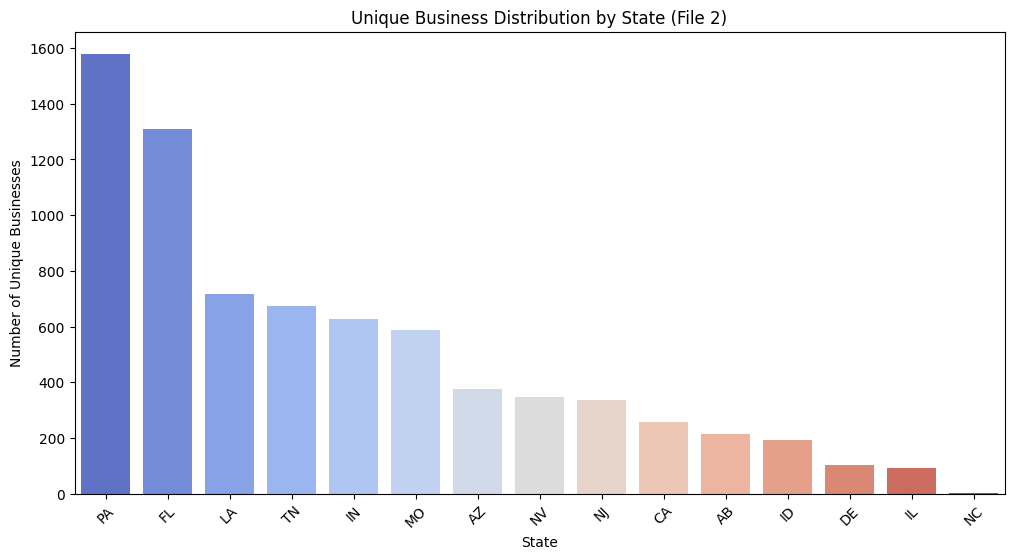

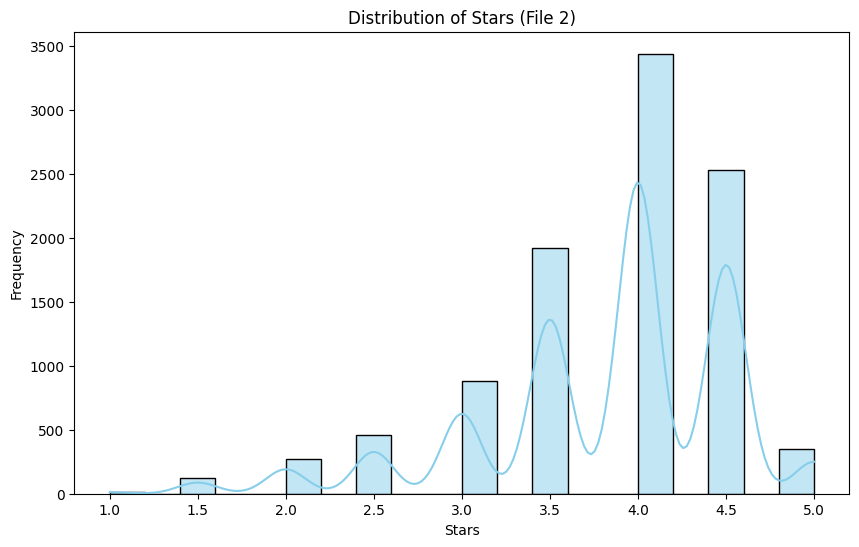


Analyzing file: C:\Users\darkr\Downloads\yelp_merged_data_3.csv
Dataset Shape: (10000, 68)
Unique businesses: 7348

Missing values per column:
 photo_id             0
business_id          0
caption           5198
label                0
image_filename       0
                  ... 
review_count         0
is_open              0
attributes          15
categories           0
hours              268
Length: 68, dtype: int64


C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\2704016425.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


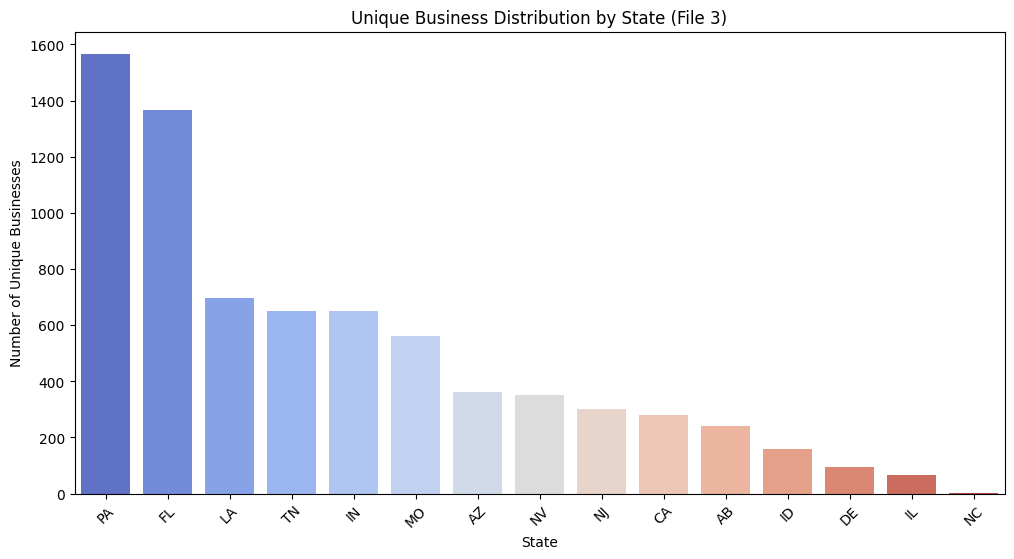

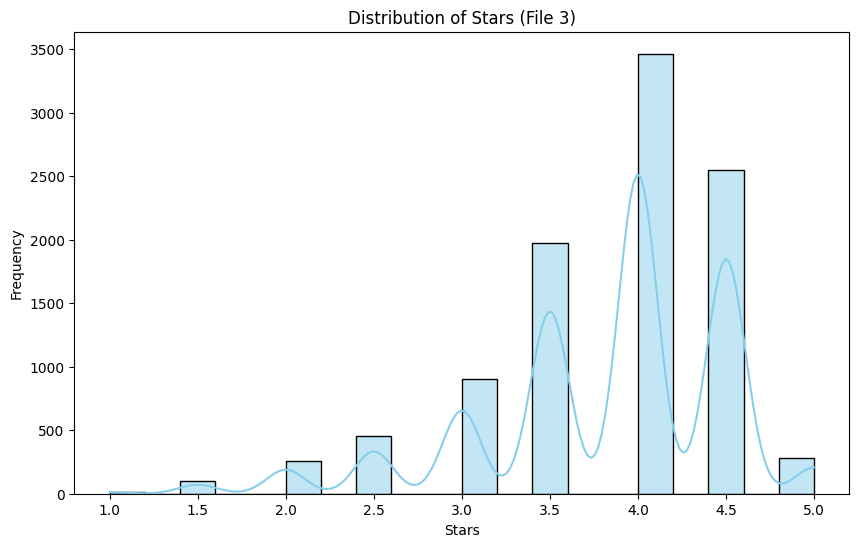


Analyzing file: C:\Users\darkr\Downloads\yelp_merged_data_4.csv
Dataset Shape: (10000, 68)
Unique businesses: 7333

Missing values per column:
 photo_id             0
business_id          0
caption           5152
label                0
image_filename       0
                  ... 
review_count         0
is_open              0
attributes          17
categories           0
hours              284
Length: 68, dtype: int64


C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\2704016425.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


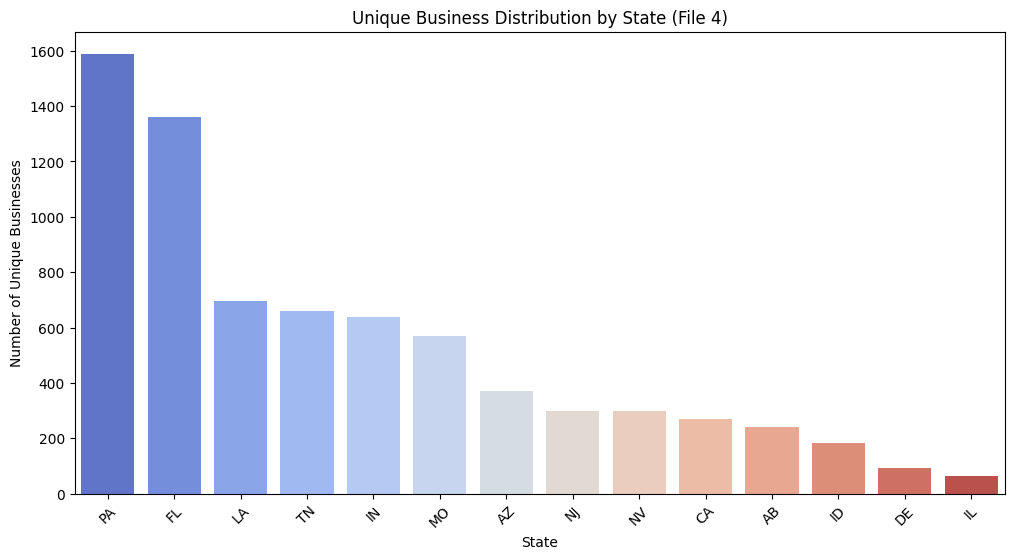

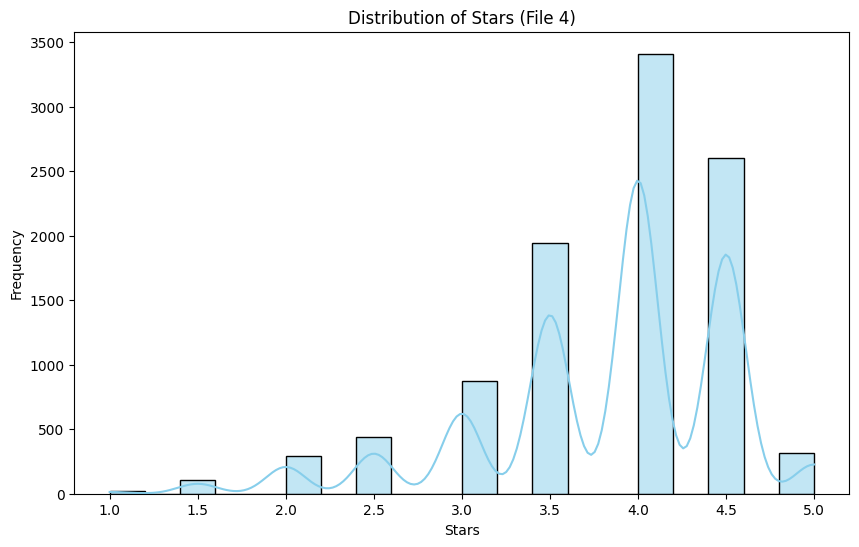


Analyzing file: C:\Users\darkr\Downloads\yelp_merged_data_5.csv
Dataset Shape: (10000, 68)
Unique businesses: 7339

Missing values per column:
 photo_id             0
business_id          0
caption           5198
label                0
image_filename       0
                  ... 
review_count         0
is_open              0
attributes          18
categories           0
hours              283
Length: 68, dtype: int64


C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\2704016425.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")


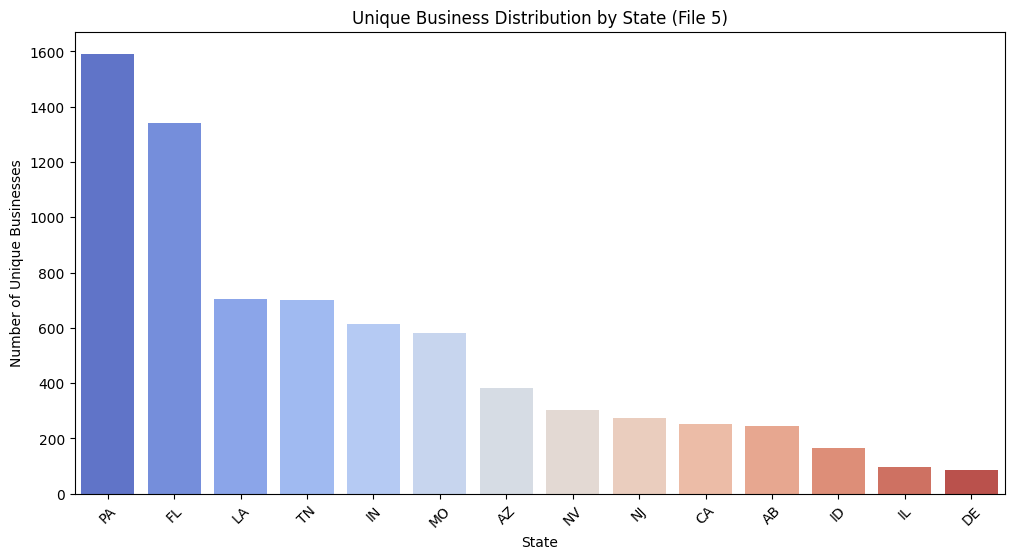

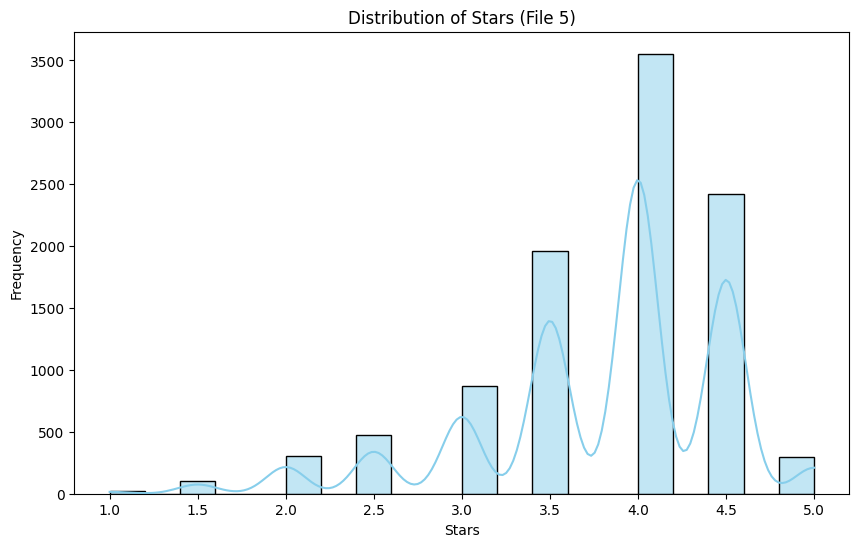

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over the 5 merged CSV files
for i in range(1, 6):
    file_path = fr"C:\Users\darkr\Downloads\yelp_merged_data_{i}.csv"
    print(f"\n============================")
    print(f"Analyzing file: {file_path}")
    print(f"============================")
    
    # Load the CSV dataset as strings to avoid type mismatches
    df = pd.read_csv(file_path, dtype=str)
    print("Dataset Shape:", df.shape)
    
    # Count unique business IDs
    if "business_id" in df.columns:
        unique_businesses = df["business_id"].nunique()
        print(f"Unique businesses: {unique_businesses}")
    else:
        print("❌ 'business_id' column not found.")
    
    # Count missing values in each column
    missing_values = df.isna().sum()
    print("\nMissing values per column:\n", missing_values)
    
    # Unique businesses per state visualization
    if "state" in df.columns and "business_id" in df.columns:
        state_counts = df.groupby("state")["business_id"].nunique().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=state_counts.index, y=state_counts.values, palette="coolwarm")
        plt.xlabel("State")
        plt.ylabel("Number of Unique Businesses")
        plt.title(f"Unique Business Distribution by State (File {i})")
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("Either 'state' or 'business_id' column is missing. Skipping state distribution plot.")
    
    # Extra EDA: Distribution of Stars (if available)
    if "stars" in df.columns:
        # Attempt to convert stars to numeric (if not already)
        df["stars"] = pd.to_numeric(df["stars"], errors="coerce")
        plt.figure(figsize=(10, 6))
        sns.histplot(df["stars"].dropna(), bins=20, kde=True, color="skyblue")
        plt.xlabel("Stars")
        plt.ylabel("Frequency")
        plt.title(f"Distribution of Stars (File {i})")
        plt.show()
    else:
        print("'stars' column not found. Skipping stars distribution analysis.")


Check if duplicate photos and to see if contents are correct:

In [4]:
import pandas as pd
from collections import defaultdict

# Dictionary to track the files each photo ID appears in.
# Keys: photo_id, Value: set of file identifiers (or file paths)
photo_id_files = defaultdict(set)

# Loop over the 5 merged CSV files
for i in range(1, 6):
    file_path = fr"C:\Users\darkr\Downloads\yelp_merged_data_{i}.csv"
    print(f"\n============================")
    print(f"Processing file: {file_path}")
    print(f"============================")
    
    try:
        # Load the CSV as strings to avoid type mismatches
        df = pd.read_csv(file_path, dtype=str)
        print("Dataset Shape:", df.shape)
    except Exception as e:
        print(f"Error reading file: {e}")
        continue

    # Check if the 'photo_id' column exists
    if "photo_id" not in df.columns:
        print("❌ 'photo_id' column not found in this file. Skipping.")
        continue

    # Get the unique photo IDs from this file (ignoring any missing values)
    unique_ids = set(df["photo_id"].dropna().unique())
    print(f"Found {len(unique_ids)} unique photo IDs in file {i}.")
    
    # Record each photo ID with the corresponding file number (or file path)
    for pid in unique_ids:
        photo_id_files[pid].add(file_path)

# After processing all files, determine which photo IDs appear in more than one CSV.
duplicate_photo_ids = {pid: len(files) for pid, files in photo_id_files.items() if len(files) > 1}

if len(duplicate_photo_ids) > 10:
    print(f"\nMore than 10 duplicate photo IDs found across the CSV files. Count: {len(duplicate_photo_ids)}")
    print("Duplicate photo IDs and the number of files they appear in:")
    for pid, count in duplicate_photo_ids.items():
        print(f"Photo ID: {pid} appears in {count} file(s).")
else:
    print(f"\nOnly {len(duplicate_photo_ids)} duplicate photo IDs found across the CSV files.")



Processing file: C:\Users\darkr\Downloads\yelp_merged_data_1.csv
Dataset Shape: (10000, 68)
Found 10000 unique photo IDs in file 1.

Processing file: C:\Users\darkr\Downloads\yelp_merged_data_2.csv
Dataset Shape: (10002, 68)
Found 10000 unique photo IDs in file 2.

Processing file: C:\Users\darkr\Downloads\yelp_merged_data_3.csv
Dataset Shape: (10000, 68)
Found 10000 unique photo IDs in file 3.

Processing file: C:\Users\darkr\Downloads\yelp_merged_data_4.csv
Dataset Shape: (10000, 68)
Found 10000 unique photo IDs in file 4.

Processing file: C:\Users\darkr\Downloads\yelp_merged_data_5.csv
Dataset Shape: (10000, 68)
Found 10000 unique photo IDs in file 5.

Only 0 duplicate photo IDs found across the CSV files.


This prepares the data for Neural Network:

In [5]:
import pandas as pd
import numpy as np
import json
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1) Define curated category list (example: 15 restaurant-related categories)
# ---------------------------
curated_categories = [
    "mexican", "fast food", "sushi", "bars", "coffee & tea", "italian", "pizza",
    "desserts", "seafood", "chinese", "thai", "nightlife", "burgers",
    "steakhouses", "breakfast & brunch"
]
curated_set = set(cat.lower() for cat in curated_categories)

# ---------------------------
# 2) Updated function to parse 15 key attributes
# ---------------------------
def parse_key_attributes(attr_str):
    """
    Parses the attributes dictionary and returns a list of 15 values in this order:
      1) RestaurantsPriceRange2: int (default 2)
      2) Alcohol: 0=none, 1=beer_and_wine, 2=full_bar
      3) HasTV: bool (1 if true, else 0)
      4) WiFi: 0=none, 1=paid, 2=free
      5) NoiseLevel: 0=quiet, 1=average, 2=loud, 3=very_loud (default 1)
      6) BikeParking: bool
      7) OutdoorSeating: bool
      8) RestaurantsTakeOut: bool
      9) RestaurantsDelivery: bool
      10) GoodForKids: bool
      11) Caters: bool
      12) RestaurantsReservations: bool
      13) RestaurantsGoodForGroups: bool
      14) HappyHour: bool
      15) WheelchairAccessible: bool
    """
    # Set default values
    price_val = 2
    alcohol_val = 0
    has_tv = 0
    wifi_val = 0
    noise_val = 1
    bike_parking = 0
    outdoor = 0
    takeout = 0
    delivery = 0
    good_for_kids = 0
    caters = 0
    reservations = 0
    good_for_groups = 0
    happy_hour = 0
    wheelchair = 0

    if pd.isna(attr_str):
        return [price_val, alcohol_val, has_tv, wifi_val, noise_val,
                bike_parking, outdoor, takeout, delivery, good_for_kids,
                caters, reservations, good_for_groups, happy_hour, wheelchair]
    
    try:
        attr_dict = json.loads(attr_str)
    except:
        try:
            attr_dict = ast.literal_eval(attr_str)
        except:
            attr_dict = {}
    if not isinstance(attr_dict, dict):
        return [price_val, alcohol_val, has_tv, wifi_val, noise_val,
                bike_parking, outdoor, takeout, delivery, good_for_kids,
                caters, reservations, good_for_groups, happy_hour, wheelchair]
    
    # 1) RestaurantsPriceRange2
    pr = str(attr_dict.get("RestaurantsPriceRange2", "2"))
    if pr.isdigit():
        price_val = int(pr)
    
    # 2) Alcohol
    alcohol_raw = str(attr_dict.get("Alcohol", "")).lower()
    if "full" in alcohol_raw:
        alcohol_val = 2
    elif "beer" in alcohol_raw or "wine" in alcohol_raw:
        alcohol_val = 1
    else:
        alcohol_val = 0
    
    # 3) HasTV
    tv_raw = str(attr_dict.get("HasTV", "False")).lower()
    if "true" in tv_raw:
        has_tv = 1
    
    # 4) WiFi
    wifi_raw = str(attr_dict.get("WiFi", "")).lower()
    if "free" in wifi_raw:
        wifi_val = 2
    elif "paid" in wifi_raw:
        wifi_val = 1
    else:
        wifi_val = 0
    
    # 5) NoiseLevel
    noise_raw = str(attr_dict.get("NoiseLevel", "average")).lower()
    if "quiet" in noise_raw:
        noise_val = 0
    elif "loud" in noise_raw:
        noise_val = 2
        if "very" in noise_raw:
            noise_val = 3
    else:
        noise_val = 1  # default to average
    
    # 6) BikeParking
    bike_raw = str(attr_dict.get("BikeParking", "False")).lower()
    if "true" in bike_raw:
        bike_parking = 1
    
    # 7) OutdoorSeating
    out_raw = str(attr_dict.get("OutdoorSeating", "False")).lower()
    if "true" in out_raw:
        outdoor = 1
    
    # 8) RestaurantsTakeOut
    takeout_raw = str(attr_dict.get("RestaurantsTakeOut", "False")).lower()
    if "true" in takeout_raw:
        takeout = 1
    
    # 9) RestaurantsDelivery
    delivery_raw = str(attr_dict.get("RestaurantsDelivery", "False")).lower()
    if "true" in delivery_raw:
        delivery = 1
    
    # 10) GoodForKids
    kids_raw = str(attr_dict.get("GoodForKids", "False")).lower()
    if "true" in kids_raw:
        good_for_kids = 1
    
    # 11) Caters
    caters_raw = str(attr_dict.get("Caters", "False")).lower()
    if "true" in caters_raw:
        caters = 1
    
    # 12) RestaurantsReservations
    reserve_raw = str(attr_dict.get("RestaurantsReservations", "False")).lower()
    if "true" in reserve_raw:
        reservations = 1
    
    # 13) RestaurantsGoodForGroups
    groups_raw = str(attr_dict.get("RestaurantsGoodForGroups", "False")).lower()
    if "true" in groups_raw:
        good_for_groups = 1
    
    # 14) HappyHour
    hh_raw = str(attr_dict.get("HappyHour", "False")).lower()
    if "true" in hh_raw:
        happy_hour = 1
    
    # 15) WheelchairAccessible
    wc_raw = str(attr_dict.get("WheelchairAccessible", "False")).lower()
    if "true" in wc_raw:
        wheelchair = 1
    
    return [price_val, alcohol_val, has_tv, wifi_val, noise_val,
            bike_parking, outdoor, takeout, delivery, good_for_kids,
            caters, reservations, good_for_groups, happy_hour, wheelchair]

def parse_hours(hours_str):
    """
    Parses the 'hours' column (JSON-like string) and computes total open hours per week.
    """
    if pd.isna(hours_str):
        return 0.0
    try:
        hours_dict = json.loads(hours_str)
    except:
        try:
            hours_dict = ast.literal_eval(hours_str)
        except:
            return 0.0
    if not isinstance(hours_dict, dict):
        return 0.0
    total_hours = 0.0
    for day, schedule in hours_dict.items():
        parts = schedule.split("-")
        if len(parts) == 2:
            open_time = parts[0].split(":")
            close_time = parts[1].split(":")
            try:
                open_hour = float(open_time[0]) + float(open_time[1]) / 60.0
                close_hour = float(close_time[0]) + float(close_time[1]) / 60.0
                if close_hour < open_hour:
                    close_hour += 24
                total_hours += (close_hour - open_hour)
            except:
                pass
    return total_hours

# ---------------------------
# 3) Load training data
# ---------------------------
train_file = r"C:\Users\darkr\Downloads\yelp_merged_data_1.csv"
df_train = pd.read_csv(train_file, dtype=str)

# ---------------------------
# 4) PCA features & Target
# ---------------------------
pca_cols = [str(i) for i in range(50)]
X_pca = df_train[pca_cols].astype(float)
y_train = df_train["stars"].astype(float)

# ---------------------------
# 5) Parse numeric metadata
#    (review_count, is_open, hours, plus the 15 key attributes)
# ---------------------------
review_count = df_train["review_count"].fillna("0").astype(float)
is_open = df_train["is_open"].fillna("0").astype(float)

# Parse hours
hours_vals = []
for h_str in df_train["hours"]:
    hours_vals.append(parse_hours(h_str))

# Parse the 15 key attributes using our new function
parsed_attr_array = []
for attr_str in df_train["attributes"]:
    attr_values = parse_key_attributes(attr_str)  # returns a list of 15 values
    parsed_attr_array.append(attr_values)
parsed_attr_array = np.array(parsed_attr_array)  # shape: (num_samples, 15)

# Combine numeric metadata: review_count, is_open, hours
X_meta_numeric = np.column_stack([
    review_count,
    is_open,
    hours_vals
])
# Append the 15 attributes → total numeric columns = 3 + 15 = 18
X_meta_numeric = np.hstack([X_meta_numeric, parsed_attr_array])

# ---------------------------
# 6) Curate categories -> multi-hot encoding
# ---------------------------
cat_multi_hot = np.zeros((len(df_train), len(curated_categories)), dtype=float)
for i, cat_str in enumerate(df_train["categories"].fillna("")):
    cat_list = [c.strip().lower() for c in cat_str.split(",") if c.strip()]
    for c in cat_list:
        if c in curated_set:
            j = curated_categories.index(c)
            cat_multi_hot[i, j] = 1.0

# Combine numeric metadata and multi-hot categories
X_meta_raw = np.hstack([X_meta_numeric, cat_multi_hot])

# ---------------------------
# 7) Scale PCA and metadata
# ---------------------------
pca_scaler = StandardScaler()
X_pca_scaled = pca_scaler.fit_transform(X_pca)

meta_scaler = StandardScaler()
X_meta_scaled = meta_scaler.fit_transform(X_meta_raw)

print("X_pca_scaled shape:", X_pca_scaled.shape)
print("X_meta_scaled shape:", X_meta_scaled.shape)
print("y_train shape:", y_train.shape)


X_pca_scaled shape: (10000, 50)
X_meta_scaled shape: (10000, 33)
y_train shape: (10000,)


This is the Neural Network

X_pca_scaled shape: (10000, 50)
X_meta_scaled shape: (10000, 33)
y_train shape: (10000,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pca_input           │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 33)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pca_dense (Dense)   │ (None, 32)        │      1,632 │ pca_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_dense (Dense)  │ (None, 16)        │        544 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pca_dropout         │ (None, 32)        │          0 │ pca_dense[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_dropout        │ (None, 16)        │          0 │ meta_dense[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ pca_dropout[0][0… │
│ (Concatenate)       │                   │            │ meta_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dense        │ (None, 32)        │      1,568 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merged_dropout      │ (None, 32)        │          0 │ merged_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 1)         │         33 │ merged_dropout[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.0597 - mae: 2.0597 - val_loss: 0.7326 - val_mae: 0.7326
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9287 - mae: 0.9287 - val_loss: 0.6061 - val_mae: 0.6061
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8314 - mae: 0.8314 - val_loss: 0.5616 - val_mae: 0.5616
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7726 - mae: 0.7726 - val_loss: 0.5357 - val_mae: 0.5357
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7313 - mae: 0.7313 - val_loss: 0.5029 - val_mae: 0.5029
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6998 - mae: 0.6998 - val_loss: 0.4989 - val_mae: 0.4989
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6688 - mae: 0.6688 - val_loss: 0.4873 - val_mae: 0.4873
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6441 - mae: 0.6441 - val_loss: 0.4858 - val_mae: 0.4858
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

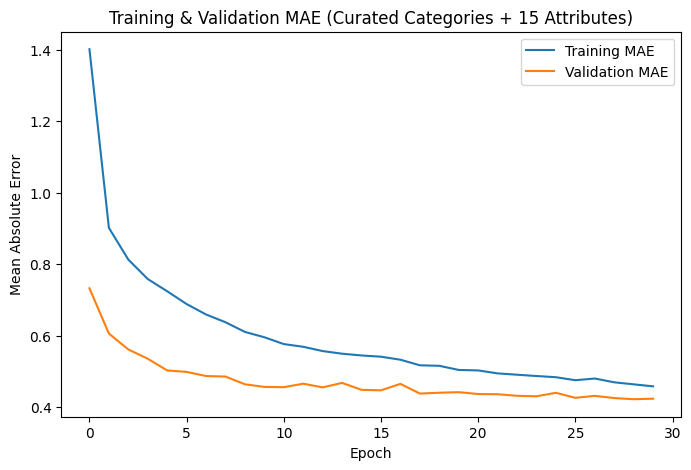


Evaluating on C:\Users\darkr\Downloads\yelp_merged_data_2.csv ...
Test MAE: 0.4418

Evaluating on C:\Users\darkr\Downloads\yelp_merged_data_3.csv ...
Test MAE: 0.4341

Evaluating on C:\Users\darkr\Downloads\yelp_merged_data_4.csv ...
Test MAE: 0.4414

Evaluating on C:\Users\darkr\Downloads\yelp_merged_data_5.csv ...
Test MAE: 0.4394

Best Test MAE: 0.4341 (from C:\Users\darkr\Downloads\yelp_merged_data_3.csv)


C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\3894415394.py:409: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_numeric_attr, x="importance", y="feature", palette="Blues_d")


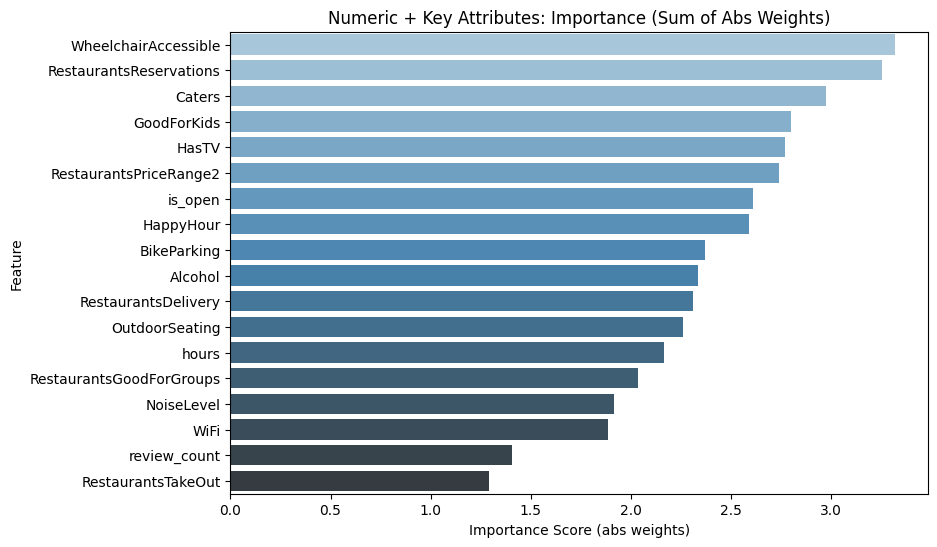

C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\3894415394.py:418: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_numeric_attr_net, x="net_effect", y="feature",


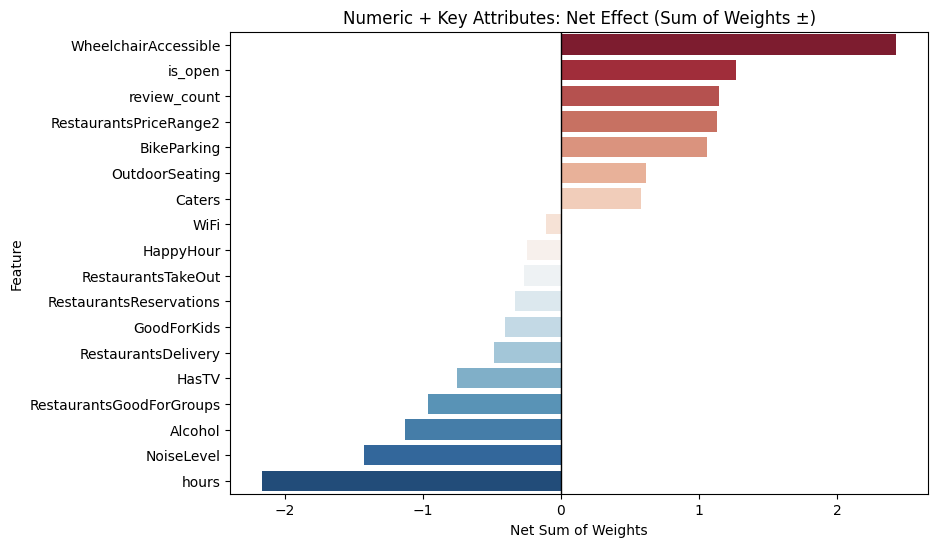

C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\3894415394.py:443: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat, x="importance", y="feature", palette="Blues_d")


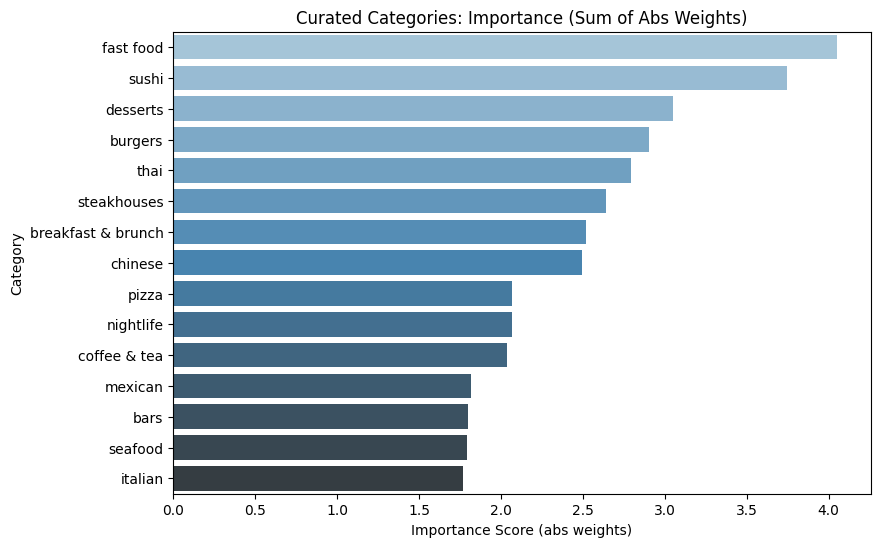

C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\3894415394.py:452: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cat_net, x="net_effect", y="feature",


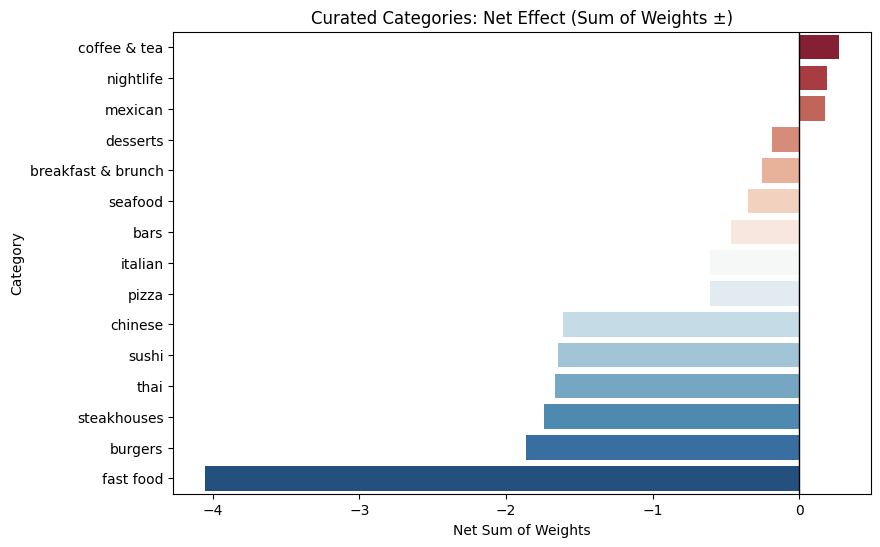

C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\3894415394.py:481: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pca_df, x="importance", y="feature", palette="Greens_d")


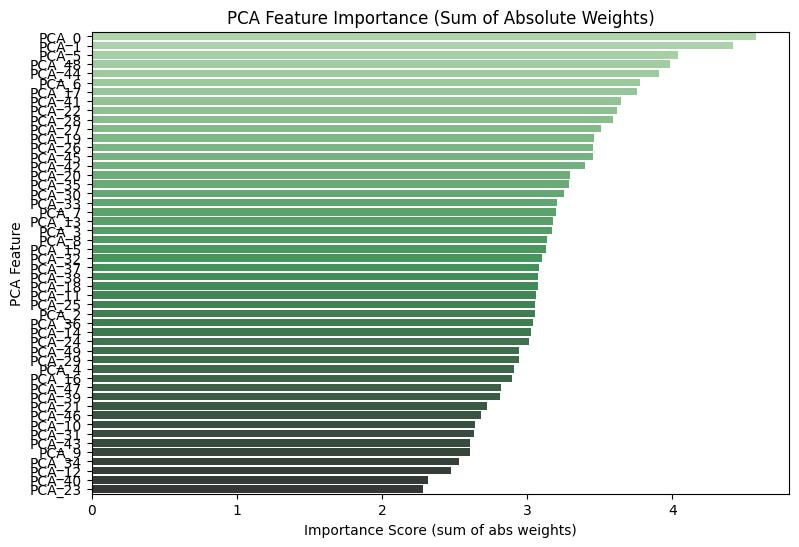

C:\Users\darkr\AppData\Local\Temp\ipykernel_26664\3894415394.py:491: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pca_df_net, x="net_effect", y="feature",


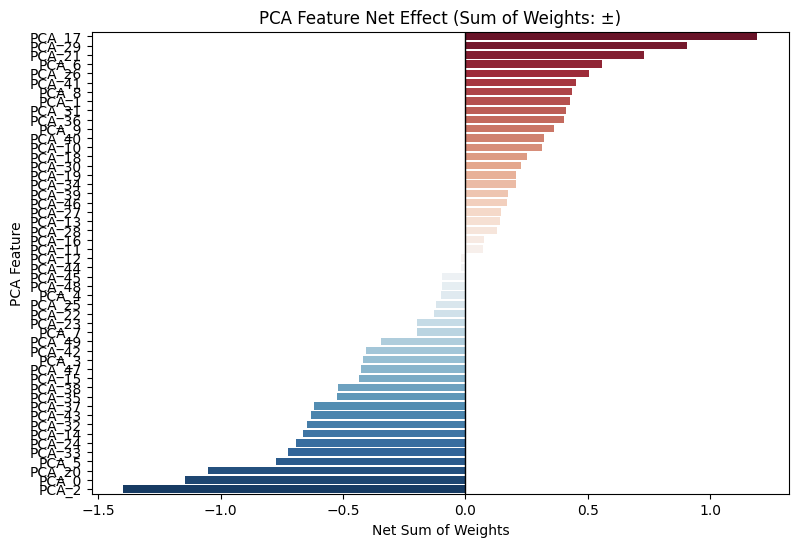

In [6]:
import numpy as np
import pandas as pd
import json
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping

#################################
# 1) Curated Categories & Helper Functions
#################################
curated_categories = [
    "mexican", "fast food", "sushi", "bars", "coffee & tea", "italian", "pizza",
    "desserts", "seafood", "chinese", "thai", "nightlife", "burgers",
    "steakhouses", "breakfast & brunch"
]
curated_set = set(cat.lower() for cat in curated_categories)

def parse_key_attributes(attr_str):
    price_val = 2
    alcohol_val = 0
    has_tv = 0
    wifi_val = 0
    noise_val = 1
    bike_parking = 0
    outdoor = 0
    takeout = 0
    delivery = 0
    good_for_kids = 0
    caters = 0
    reservations = 0
    good_for_groups = 0
    happy_hour = 0
    wheelchair = 0

    if pd.isna(attr_str):
        return [price_val, alcohol_val, has_tv, wifi_val, noise_val,
                bike_parking, outdoor, takeout, delivery, good_for_kids,
                caters, reservations, good_for_groups, happy_hour, wheelchair]
    
    try:
        attr_dict = json.loads(attr_str)
    except:
        try:
            attr_dict = ast.literal_eval(attr_str)
        except:
            attr_dict = {}
    if not isinstance(attr_dict, dict):
        return [price_val, alcohol_val, has_tv, wifi_val, noise_val,
                bike_parking, outdoor, takeout, delivery, good_for_kids,
                caters, reservations, good_for_groups, happy_hour, wheelchair]
    
    # 1) RestaurantsPriceRange2
    pr = str(attr_dict.get("RestaurantsPriceRange2", "2"))
    if pr.isdigit():
        price_val = int(pr)
    
    # 2) Alcohol
    alcohol_raw = str(attr_dict.get("Alcohol", "")).lower()
    if "full" in alcohol_raw:
        alcohol_val = 2
    elif "beer" in alcohol_raw or "wine" in alcohol_raw:
        alcohol_val = 1
    else:
        alcohol_val = 0
    
    # 3) HasTV
    tv_raw = str(attr_dict.get("HasTV", "False")).lower()
    if "true" in tv_raw:
        has_tv = 1
    
    # 4) WiFi
    wifi_raw = str(attr_dict.get("WiFi", "")).lower()
    if "free" in wifi_raw:
        wifi_val = 2
    elif "paid" in wifi_raw:
        wifi_val = 1
    else:
        wifi_val = 0
    
    # 5) NoiseLevel
    noise_raw = str(attr_dict.get("NoiseLevel", "average")).lower()
    if "quiet" in noise_raw:
        noise_val = 0
    elif "loud" in noise_raw:
        noise_val = 2
        if "very" in noise_raw:
            noise_val = 3
    else:
        noise_val = 1
    
    # 6) BikeParking
    bike_raw = str(attr_dict.get("BikeParking", "False")).lower()
    if "true" in bike_raw:
        bike_parking = 1
    
    # 7) OutdoorSeating
    out_raw = str(attr_dict.get("OutdoorSeating", "False")).lower()
    if "true" in out_raw:
        outdoor = 1
    
    # 8) RestaurantsTakeOut
    takeout_raw = str(attr_dict.get("RestaurantsTakeOut", "False")).lower()
    if "true" in takeout_raw:
        takeout = 1
    
    # 9) RestaurantsDelivery
    delivery_raw = str(attr_dict.get("RestaurantsDelivery", "False")).lower()
    if "true" in delivery_raw:
        delivery = 1
    
    # 10) GoodForKids
    kids_raw = str(attr_dict.get("GoodForKids", "False")).lower()
    if "true" in kids_raw:
        good_for_kids = 1
    
    # 11) Caters
    caters_raw = str(attr_dict.get("Caters", "False")).lower()
    if "true" in caters_raw:
        caters = 1
    
    # 12) RestaurantsReservations
    reserve_raw = str(attr_dict.get("RestaurantsReservations", "False")).lower()
    if "true" in reserve_raw:
        reservations = 1
    
    # 13) RestaurantsGoodForGroups
    groups_raw = str(attr_dict.get("RestaurantsGoodForGroups", "False")).lower()
    if "true" in groups_raw:
        good_for_groups = 1
    
    # 14) HappyHour
    hh_raw = str(attr_dict.get("HappyHour", "False")).lower()
    if "true" in hh_raw:
        happy_hour = 1
    
    # 15) WheelchairAccessible
    wc_raw = str(attr_dict.get("WheelchairAccessible", "False")).lower()
    if "true" in wc_raw:
        wheelchair = 1
    
    return [
        price_val, alcohol_val, has_tv, wifi_val, noise_val,
        bike_parking, outdoor, takeout, delivery, good_for_kids,
        caters, reservations, good_for_groups, happy_hour, wheelchair
    ]

def parse_hours(hours_str):
    if pd.isna(hours_str):
        return 0.0
    try:
        hours_dict = json.loads(hours_str)
    except:
        try:
            hours_dict = ast.literal_eval(hours_str)
        except:
            return 0.0
    if not isinstance(hours_dict, dict):
        return 0.0
    total_hours = 0.0
    for day, schedule in hours_dict.items():
        parts = schedule.split("-")
        if len(parts) == 2:
            open_time = parts[0].split(":")
            close_time = parts[1].split(":")
            try:
                open_hour = float(open_time[0]) + float(open_time[1]) / 60.0
                close_hour = float(close_time[0]) + float(close_time[1]) / 60.0
                if close_hour < open_hour:
                    close_hour += 24
                total_hours += (close_hour - open_hour)
            except:
                pass
    return total_hours

#################################
# 2) Load Training Data
#################################
train_file = r"C:\Users\darkr\Downloads\yelp_merged_data_1.csv"
df_train = pd.read_csv(train_file, dtype=str)

# PCA features & target
pca_cols = [str(i) for i in range(50)]
X_pca = df_train[pca_cols].astype(float)
y_train = df_train["stars"].astype(float)

# Parse numeric metadata
review_count = df_train["review_count"].fillna("0").astype(float)
is_open = df_train["is_open"].fillna("0").astype(float)
hours_vals = [parse_hours(h) for h in df_train["hours"]]

# Parse 15 key attributes
parsed_attr_array = []
for attr_str in df_train["attributes"]:
    parsed_attr_array.append(parse_key_attributes(attr_str))
parsed_attr_array = np.array(parsed_attr_array)

# Combine numeric metadata (3 columns) + 15 attributes = 18
X_meta_numeric = np.column_stack([review_count, is_open, hours_vals])
X_meta_numeric = np.hstack([X_meta_numeric, parsed_attr_array])

# Multi-hot encode curated categories (15 categories)
cat_multi_hot = np.zeros((len(df_train), len(curated_categories)), dtype=float)
for i, cat_str in enumerate(df_train["categories"].fillna("")):
    cat_list = [c.strip().lower() for c in cat_str.split(",") if c.strip()]
    for c in cat_list:
        if c in curated_set:
            j = curated_categories.index(c)
            cat_multi_hot[i, j] = 1.0

# Combine numeric+attributes with curated categories
X_meta_raw = np.hstack([X_meta_numeric, cat_multi_hot])

# Scale
pca_scaler = StandardScaler()
X_pca_scaled = pca_scaler.fit_transform(X_pca)

meta_scaler = StandardScaler()
X_meta_scaled = meta_scaler.fit_transform(X_meta_raw)

# Build metadata feature names
#  - first 3:  ["review_count", "is_open", "hours"]
#  - next 15:  ["attr_0", ..., "attr_14"]
#  - last 15:  curated_categories
# Build metadata feature names:
# First 3: features directly from the CSV
# Next 15: parsed key attributes (in this exact order)
#    1) RestaurantsPriceRange2
#    2) Alcohol
#    3) HasTV
#    4) WiFi
#    5) NoiseLevel
#    6) BikeParking
#    7) OutdoorSeating
#    8) RestaurantsTakeOut
#    9) RestaurantsDelivery
#    10) GoodForKids
#    11) Caters
#    12) RestaurantsReservations
#    13) RestaurantsGoodForGroups
#    14) HappyHour
#    15) WheelchairAccessible
# Last 15: the curated categories from your list
meta_feature_names = (
    ["review_count", "is_open", "hours"] +
    [
        "RestaurantsPriceRange2", "Alcohol", "HasTV", "WiFi", "NoiseLevel",
        "BikeParking", "OutdoorSeating", "RestaurantsTakeOut", "RestaurantsDelivery",
        "GoodForKids", "Caters", "RestaurantsReservations", "RestaurantsGoodForGroups",
        "HappyHour", "WheelchairAccessible"
    ] +
    curated_categories
)


print("X_pca_scaled shape:", X_pca_scaled.shape)
print("X_meta_scaled shape:", X_meta_scaled.shape)
print("y_train shape:", y_train.shape)

#################################
# 3) Define Multi-Input Model
#################################
pca_input = Input(shape=(X_pca_scaled.shape[1],), name="pca_input")
x1 = Dense(32, activation='relu', name="pca_dense")(pca_input)
x1 = Dropout(0.2, name="pca_dropout")(x1)

meta_input = Input(shape=(X_meta_scaled.shape[1],), name="meta_input")
x2 = Dense(16, activation='relu', name="meta_dense")(meta_input)
x2 = Dropout(0.2, name="meta_dropout")(x2)

merged = concatenate([x1, x2], name="concatenate")
x = Dense(32, activation='relu', name="merged_dense")(merged)
x = Dropout(0.2, name="merged_dropout")(x)
output = Dense(1, activation='linear', name="final_output")(x)

model = Model(inputs=[pca_input, meta_input], outputs=output)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

#################################
# 4) Train the Model
#################################
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_pca_scaled, X_meta_scaled],
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

#################################
# 5) Plot Training vs. Validation MAE
#################################
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training & Validation MAE (Curated Categories + 15 Attributes)')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

#################################
# 6) Evaluate on Test Files
#################################
test_files = [
    r"C:\Users\darkr\Downloads\yelp_merged_data_2.csv",
    r"C:\Users\darkr\Downloads\yelp_merged_data_3.csv",
    r"C:\Users\darkr\Downloads\yelp_merged_data_4.csv",
    r"C:\Users\darkr\Downloads\yelp_merged_data_5.csv"
]

def parse_test_data(df_test):
    X_test_pca = df_test[pca_cols].astype(float)
    X_test_pca_scaled = pca_scaler.transform(X_test_pca)
    
    rc = df_test["review_count"].fillna("0").astype(float)
    io = df_test["is_open"].fillna("0").astype(float)
    hours_list = [parse_hours(h) for h in df_test["hours"]]
    
    parsed_attr = []
    for attr_str in df_test["attributes"]:
        parsed_attr.append(parse_key_attributes(attr_str))
    parsed_attr = np.array(parsed_attr)
    
    X_test_meta_numeric = np.column_stack([rc, io, hours_list])
    X_test_meta_numeric = np.hstack([X_test_meta_numeric, parsed_attr])
    
    cat_multi_hot_test = np.zeros((len(df_test), len(curated_categories)), dtype=float)
    for i, cat_str in enumerate(df_test["categories"].fillna("")):
        cat_list = [c.strip().lower() for c in cat_str.split(",") if c.strip()]
        for c in cat_list:
            if c in curated_set:
                j = curated_categories.index(c)
                cat_multi_hot_test[i, j] = 1.0
    
    X_test_meta_raw = np.hstack([X_test_meta_numeric, cat_multi_hot_test])
    X_test_meta_scaled = meta_scaler.transform(X_test_meta_raw)
    
    y_test = df_test["stars"].astype(float)
    return X_test_pca_scaled, X_test_meta_scaled, y_test

best_mae = float('inf')
best_file = None

for test_file in test_files:
    print(f"\nEvaluating on {test_file} ...")
    df_test = pd.read_csv(test_file, dtype=str)
    
    if not set(pca_cols + ["stars"]).issubset(df_test.columns):
        print("Missing PCA or star columns. Skipping.")
        continue
    
    X_test_pca_scaled, X_test_meta_scaled, y_test = parse_test_data(df_test)
    test_loss, test_mae = model.evaluate([X_test_pca_scaled, X_test_meta_scaled], y_test, verbose=0)
    print(f"Test MAE: {test_mae:.4f}")
    
    if test_mae < best_mae:
        best_mae = test_mae
        best_file = test_file

print(f"\nBest Test MAE: {best_mae:.4f} (from {best_file})")

#################################
# 7) Separate Metadata Features & Plot
#################################

# --- Get the metadata layer weights ---
meta_dense_layer = model.get_layer("meta_dense")
meta_weights, meta_bias = meta_dense_layer.get_weights()  # shape: (metadata_dim, 16)

# --- Compute importance & net effect for ALL metadata features ---
meta_importance = np.sum(np.abs(meta_weights), axis=1)
meta_net_effect = np.sum(meta_weights, axis=1)

# Build a DataFrame of all metadata features
meta_df_all = pd.DataFrame({
    "feature": meta_feature_names,
    "importance": meta_importance,
    "net_effect": meta_net_effect
})

# 1) Numeric + Key Attributes
#    first 18 features: 3 numeric + 15 attributes
numeric_attr_indices = list(range(18))
numeric_attr_names = meta_feature_names[:18]

numeric_attr_importance = meta_importance[numeric_attr_indices]
numeric_attr_net_effect = meta_net_effect[numeric_attr_indices]

df_numeric_attr = pd.DataFrame({
    "feature": numeric_attr_names,
    "importance": numeric_attr_importance,
    "net_effect": numeric_attr_net_effect
})

# Plot 1: Numeric+Attr Importance
df_numeric_attr = df_numeric_attr.sort_values("importance", ascending=False)
plt.figure(figsize=(9, 6))
sns.barplot(data=df_numeric_attr, x="importance", y="feature", palette="Blues_d")
plt.title("Numeric + Key Attributes: Importance (Sum of Abs Weights)")
plt.xlabel("Importance Score (abs weights)")
plt.ylabel("Feature")
plt.show()

# Plot 2: Numeric+Attr Net Effect
df_numeric_attr_net = df_numeric_attr.sort_values("net_effect", ascending=False)
plt.figure(figsize=(9, 6))
sns.barplot(data=df_numeric_attr_net, x="net_effect", y="feature",
            palette="RdBu", orient="h")
plt.axvline(0, color='black', linewidth=1)
plt.title("Numeric + Key Attributes: Net Effect (Sum of Weights ±)")
plt.xlabel("Net Sum of Weights")
plt.ylabel("Feature")
plt.show()

# 2) Curated Categories
#    last 15 features
cat_indices = list(range(18, 18 + len(curated_categories)))
cat_names = meta_feature_names[18:]

cat_importance = meta_importance[cat_indices]
cat_net_effect = meta_net_effect[cat_indices]

df_cat = pd.DataFrame({
    "feature": cat_names,
    "importance": cat_importance,
    "net_effect": cat_net_effect
})

# Plot 3: Curated Categories Importance
df_cat = df_cat.sort_values("importance", ascending=False)
plt.figure(figsize=(9, 6))
sns.barplot(data=df_cat, x="importance", y="feature", palette="Blues_d")
plt.title("Curated Categories: Importance (Sum of Abs Weights)")
plt.xlabel("Importance Score (abs weights)")
plt.ylabel("Category")
plt.show()

# Plot 4: Curated Categories Net Effect
df_cat_net = df_cat.sort_values("net_effect", ascending=False)
plt.figure(figsize=(9, 6))
sns.barplot(data=df_cat_net, x="net_effect", y="feature",
            palette="RdBu", orient="h")
plt.axvline(0, color='black', linewidth=1)
plt.title("Curated Categories: Net Effect (Sum of Weights ±)")
plt.xlabel("Net Sum of Weights")
plt.ylabel("Category")
plt.show()

#################################
# 8) PCA Feature Importance & Net Effect
#################################
pca_dense_layer = model.get_layer("pca_dense")
pca_weights, pca_bias = pca_dense_layer.get_weights()  # shape: (pca_dim, 32)

pca_importance = np.sum(np.abs(pca_weights), axis=1)
pca_net_effect = np.sum(pca_weights, axis=1)

pca_feature_names = [f"PCA_{i}" for i in range(len(pca_importance))]

pca_df = pd.DataFrame({
    "feature": pca_feature_names,
    "importance": pca_importance,
    "net_effect": pca_net_effect
})

# Sort by importance
pca_df = pca_df.sort_values("importance", ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(data=pca_df, x="importance", y="feature", palette="Greens_d")
plt.title("PCA Feature Importance (Sum of Absolute Weights)")
plt.xlabel("Importance Score (sum of abs weights)")
plt.ylabel("PCA Feature")
plt.show()

# Sort by net effect
pca_df_net = pca_df.sort_values("net_effect", ascending=False)

plt.figure(figsize=(9, 6))
sns.barplot(data=pca_df_net, x="net_effect", y="feature",
            palette="RdBu", orient="h")
plt.axvline(0, color='black', linewidth=1)
plt.title("PCA Feature Net Effect (Sum of Weights: ±)")
plt.xlabel("Net Sum of Weights")
plt.ylabel("PCA Feature")
plt.show()
